In [20]:
###import Lib to process  MetaFile 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.feature_extraction import stop_words
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from langdetect import detect 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
###Use the below command to install worlcloud libraries
###conda install -c conda-forge wordcloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import json
import random
###Use the below command to install pyLDAvis libraries
###pip install pyldavis 
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [22]:
###########Load Metadata file
current_path = os.getcwd()
metadata_path = f'{current_path}/551982_1230614_bundle_archive/metadata.csv'
pd.set_option('display.max_colwidth', None) 


#### Convert Metadata file to dataframe
meta_df = pd.read_csv(metadata_path , usecols=['sha','title', 'abstract' , 'publish_time' ,'pdf_json_files'])
print(f'Initial number of publications {len(meta_df)}')

####Drop Rows with Empty Key columns
####All documents that are missing a title or abstract or do not have a pdf_json equivalent will be dropped
meta_df.dropna(subset=['pdf_json_files', 'title' ,'abstract' ] , inplace=True)
print(f'Initial number of publications after NAN dropped {len(meta_df)}')


####Convert title and extract to lower case 
meta_df['title']=meta_df['title'].str.lower() 
meta_df['abstract']=meta_df['abstract'].str.lower()

print(meta_df.info())

Initial number of publications 138794
Initial number of publications after NAN dropped 55365
<class 'pandas.core.frame.DataFrame'>
Int64Index: 55365 entries, 0 to 138793
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sha             55365 non-null  object
 1   title           55365 non-null  object
 2   abstract        55365 non-null  object
 3   publish_time    55365 non-null  object
 4   pdf_json_files  55365 non-null  object
dtypes: object(5)
memory usage: 2.5+ MB
None


In order to ensure that the results from the topic modeling exercise are targeted and specific, a keyword search, on the abstracts of each document, is used to narrow the number of documents upon which the topic modeling algorithms will be executed.

In [23]:
###Search Abstract d
meta_df['SerchFlg1']= meta_df['abstract'].str.contains('non-pharmaceutical')
meta_df['SerchFlg2']= meta_df['abstract'].str.contains('npi') 
print(f'Number of documents containing the keyword non-pharmaceutical:',len(meta_df[meta_df['SerchFlg1']==True]))
print(f'Number of documents containing the keyword npi:',len(meta_df[meta_df['SerchFlg2']==True])) 

meta_df =meta_df[(meta_df['SerchFlg1']==True) | (meta_df['SerchFlg2']==True)]

print('Total number of documents (excluding duplicates):' , len(meta_df))


Number of documents containing the keyword non-pharmaceutical: 172
Number of documents containing the keyword npi: 67
Total number of documents (excluding duplicates): 203


In [9]:
#meta_df[meta_df['sha'=='7e951ff88008de16ecc2aeaecea54ed5b5c84abf']]
meta_df.head()

,sha,title,abstract,publish_time,pdf_json_files,SerchFlg1,SerchFlg2
83,9b7a0ad7b6c7f59e7a6cf1dc9d07912a273d19b5,the waiting time for inter-country spread of pandemic influenza,"background: the time delay between the start of an influenza pandemic and its subsequent initiation in other countries is highly relevant to preparedness planning. we quantify the distribution of this random time in terms of the separate components of this delay, and assess how the delay may be extended by non-pharmaceutical interventions. methods and findings: the model constructed for this time delay accounts for: (i) epidemic growth in the source region, (ii) the delay until an infected individual from the source region seeks to travel to an at-risk country, (iii) the chance that infected travelers are detected by screening at exit and entry borders, (iv) the possibility of in-flight transmission, (v) the chance that an infected arrival might not initiate an epidemic, and (vi) the delay until infection in the at-risk country gathers momentum. efforts that reduce the disease reproduction number in the source region below two and severe travel restrictions are most effective for delaying a local epidemic, and under favourable circumstances, could add several months to the delay. on the other hand, the model predicts that border screening for symptomatic infection, wearing a protective mask during travel, promoting early presentation of cases arising among arriving passengers and moderate reduction in travel volumes increase the delay only by a matter of days or weeks. elevated in-flight transmission reduces the delay only minimally. conclusions: the delay until an epidemic of pandemic strain influenza is imported into an at-risk country is largely determined by the course of the epidemic in the source region and the number of travelers attempting to enter the at-risk country, and is little affected by non-pharmaceutical interventions targeting these travelers. short of preventing international travel altogether, eradicating a nascent pandemic in the source region appears to be the only reliable method of preventing country-to-country spread of a pandemic strain of influenza.",2007-01-03,document_parses/pdf_json/9b7a0ad7b6c7f59e7a6cf1dc9d07912a273d19b5.json,True,False
106,555bbbbd23da02c97c6a4238937e31b5781438a9,influenza pandemic intervention planning using influsim: pharmaceutical and non- pharmaceutical interventions,"background: influenza pandemic preparedness plans are currently developed and refined on national and international levels. much attention has been given to the administration of antiviral drugs, but contact reduction can also be an effective part of mitigation strategies and has the advantage to be not limited per se. the effectiveness of these interventions depends on various factors which must be explored by sensitivity analyses, based on mathematical models. methods: we use the freely available planning tool influsim to investigate how pharmaceutical and non-pharmaceutical interventions can mitigate an influenza pandemic. in particular, we examine how intervention schedules, restricted stockpiles and contact reduction (social distancing measures and isolation of cases) determine the course of a pandemic wave and the success of interventions. results: a timely application of antiviral drugs combined with a quick implementation of contact reduction measures is required to substantially protract the peak of the epidemic and reduce its height. delays in the initiation of antiviral treatment (e.g. because of parsimonious use of a limited stockpile) result in much more pessimistic outcomes and can even lead to the paradoxical effect that the stockpile is depleted earlier compared to early distribution of antiviral drugs. conclusion: pharmaceutical and non-pharmaceutical measures should not be used exclusively. the protraction of the pandemic wave is essential to win time while waiting for vaccine development and production. however, it is

As depicted below a majority of the documents are created/published in the years 2019-2020

In [24]:
#Set plot style to ggplot
plt.style.use("ggplot")
#Extract publication year from 'Publish_Time' field
meta_df['publish_year']=meta_df['publish_time'].apply(lambda x:  x[:4])

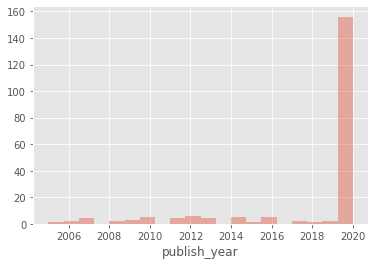

In [25]:
sns.distplot(meta_df['publish_year'], kde=False, bins=20)

In [26]:
#A lambda function is run on the title field to do a quick scan of the publication language 
%timeit meta_df['language']= meta_df['title'].apply(lambda x: detect(x))
meta_df['language'].value_counts()

890 ms ± 37.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


en    202
de      1
Name: language, dtype: int64

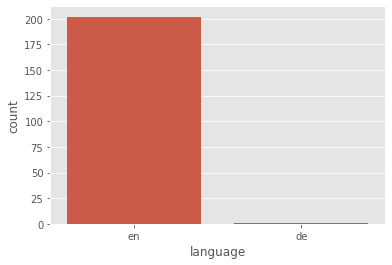

In [27]:
plt.style.use("ggplot")
#Vislualize language data using a countplot. A majority of the documents are created in english
sns.countplot(x='language', data=meta_df)

In [28]:
#####Only English articles from last 2 years are retained
final_meta_df = meta_df[(meta_df['language']=='en')  & ( meta_df['publish_year'] > '2018' )]

In [29]:
print(final_meta_df.shape) #157 publications are retained

(157, 9)


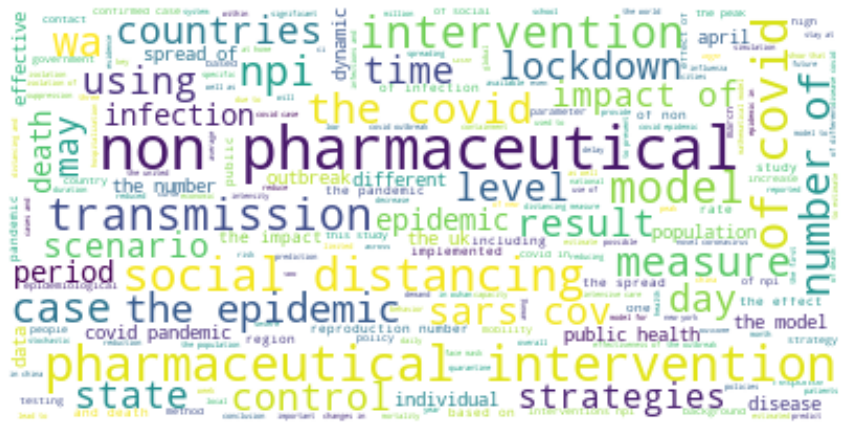

In [30]:
#Append abstract's together to generate word cloud
text = " ".join(abstract for abstract in final_meta_df['abstract'] ) 

# Create and generate a word cloud image: 
wordcloud = WordCloud(background_color="white").generate(text)
 
# Display the generated image:
plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [34]:
#The below function is used to extract body text for each file and append it together
def load_json_doc(file_name ):
      
    body_text = ''
    try:
        with open(file_name) as json_file:
                 json_data = json.load(json_file)
                 for  text in json_data['body_text']:     
                        text = text['text'].strip().replace("\n", " ").replace("\r", " ")
                        text =  text.lower()
                        try: 
                            if len( text) > 0:
                                body_text = body_text + '\n' + text
                        except:
                                   pass
                            
    except IOError: 
          pass
          

    return body_text 
    

In [35]:
file_path =  current_path +'/551982_1230614_bundle_archive/'
print(file_path)

/Users/abhishekjonnavittula/Documents/Kaggle_Challenges/551982_1230614_bundle_archive/


In [36]:
Final_Data =[] 
Store_dataInfo = pd.DataFrame([])

for  index , row  in final_meta_df.iterrows():
            #Some of the publications are spread across multiple JSONs 
            if  row['pdf_json_files' ].find(";") > 0: 
                 file = row['pdf_json_files' ][:row['pdf_json_files' ].find(";")]
            else:    
                 file_name = file_path + row['pdf_json_files'] 
    
            Body_Text =  load_json_doc(file_name )
        
            if len(Body_Text) > 0:
                Final_Data.append(Body_Text)
                l= len(Final_Data)-1
                Store_dataInfo = Store_dataInfo.append(pd.DataFrame({'FileName':  file_name, 'Title' : row['title' ] , 'Body_Text':Body_Text , 'FinalDataIndex': l}, index=[0]), ignore_index=True)
                                
print("Total Text loaded " ,len(Final_Data))
print(Store_dataInfo.info())
print(Store_dataInfo.head(3))


Total Text loaded  157
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   FileName        157 non-null    object
 1   Title           157 non-null    object
 2   Body_Text       157 non-null    object
 3   FinalDataIndex  157 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 5.0+ KB
None
                                                                                                                                                       FileName  \
0  /Users/abhishekjonnavittula/Documents/Kaggle_Challenges/551982_1230614_bundle_archive/document_parses/pdf_json/85c6f63e581817cce1d68e6a5bb856fdbe390d17.json   
1  /Users/abhishekjonnavittula/Documents/Kaggle_Challenges/551982_1230614_bundle_archive/document_parses/pdf_json/c3de717508f4b790f53e9e998ef61c5f27b00ce7.json   
2  /Users/abhishekjonnavittula/Documents/Kaggle_Challenges/551982

In [60]:
custom_stop_words = ['doi','preprint','copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure',
'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier',
'PMC', 'CZI', 'www','a','about','above']

stop_words_list = stop_words.ENGLISH_STOP_WORDS.union(custom_stop_words)

In [61]:
##Initialize count vectorizer
cv = CountVectorizer(
                        max_df=0.7, #Ignore terms that occur in 70% of the documents 
                        min_df=0.1, #Ignore terms that occur in less than 10% of the documents 
                        token_pattern='[a-zA-Z]{4,}', #remove works less than 4 characters
                        stop_words=stop_words_list# remove english stop words
                    )
### document term matrix
dtm=cv.fit_transform(Final_Data) #initialize the document term matrix


/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['elsevier'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [62]:
print(len(cv.get_feature_names()))
print(f'Shape Rows by Word {dtm.shape}')

1796
Shape Rows by Word (157, 1796)


In [89]:
LDA = LatentDirichletAllocation(n_components=4,random_state=42)
# This can take awhile, we're dealing with a large amount of documents!
%timeit LDA.fit(dtm)

2.01 s ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [92]:
print(f'Total number of topics:',len(LDA.components_))
# Numerical representation of values present in each of the 4 clusters
print(LDA.components_)

Total number of topics: 4
[[29.62147628 47.32253222  9.95054214 ...  9.43556218  8.85738081
   9.62793863]
 [10.92089896 24.44977583 22.16521679 ... 15.60401731 32.51399122
   0.26293516]
 [13.2198387  36.16507009 54.97196162 ... 11.69263316  8.34754443
  83.47150665]
 [18.23778605 39.06262186 41.91227946 ...  0.26778734 10.28108355
  51.63761956]]


In [94]:
#Display top 30 words in each topic
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 30 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-30:]])
    print('\n')

THE TOP 30 WORDS FOR TOPIC #0
['week', 'region', 'potential', 'april', 'coronavirus', 'school', 'policy', 'south', 'restrictions', 'likely', 'hand', 'india', 'home', 'approach', 'information', 'work', 'government', 'country', 'perpetuity', 'states', 'granted', 'funder', 'holder', 'national', 'wuhan', 'npis', 'economic', 'travel', 'international', 'lockdown']


THE TOP 30 WORDS FOR TOPIC #1
['symptomatic', 'critical', 'viral', 'death', 'human', 'beds', 'years', 'capacity', 'respiratory', 'contacts', 'holder', 'perpetuity', 'assumed', 'funder', 'granted', 'confirmed', 'january', 'deaths', 'healthcare', 'severe', 'international', 'isolation', 'asymptomatic', 'hospital', 'wuhan', 'symptoms', 'care', 'risk', 'sars', 'patients']


THE TOP 30 WORDS FOR TOPIC #2
['household', 'entire', 'reduction', 'exposed', 'mortality', 'deaths', 'baseline', 'contacts', 'reproduction', 'strategy', 'simulations', 'stochastic', 'strategies', 'probability', 'york', 'cumulative', 'tracing', 'parameter', 'scenari

In [90]:
#The pyLDAvis libraries are used to visualize the topics and the top 30 words in each topic
pyLDAvis.sklearn.prepare(LDA,dtm,cv)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.082609 -0.038725       1        1  32.348199
2     -0.097854  0.078025       2        1  29.367372
0      0.042178 -0.102704       3        1  20.307287
1      0.138285  0.063404       4        1  17.977141, topic_info=             Term         Freq        Total Category  logprob  loglift
1151     patients   659.000000   659.000000  Default  30.0000  30.0000
958      lockdown  1001.000000  1001.000000  Default  29.0000  29.0000
1420         risk   522.000000   522.000000  Default  28.0000  28.0000
1436         sars   580.000000   580.000000  Default  27.0000  27.0000
1088         npis   889.000000   889.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
691        funder   178.377013  1268.576154   Topic4  -5.2509  -0.2457
757        holder   172.907867  1202.579315   Topic4  -5.2821  -0.2234
1161   perpetuity   173.449923  1263.619925   Topic4  -5.2789  -0.2698
368      critical   149.119645   420.600024   Topic4  -5.4301   0.6791
1624  symptomatic   145.011450   475.069423   Topic4  -5.4580   0.5294

[289 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5         1  0.084420     access
5         3  0.759777     access
5         4  0.147734     access
43        1  0.910212  adjusting
43        2  0.091021  adjusting
...     ...       ...        ...
1789      3  0.255790      years
1789      4  0.660103      years
1792      1  0.105219       york
1792      2  0.868908       york
1792      3  0.023759       york

[780 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

In [73]:
#Save topic results
topic_results = LDA.transform(dtm)

In [74]:
#Display shape of topic_results object
topic_results.shape

(157, 4)

In [75]:
#Display shape of topic_results object
print(topic_results.argmax(axis=0))

[  2 150 127  82]


In [79]:
#Add topics to publication dataframe
Store_dataInfo['LDAtopic']= topic_results.argmax(axis=1)

In [95]:
#Display title associated with topic 0
Store_dataInfo[Store_dataInfo['LDAtopic']==0][['Title' , 'LDAtopic']].head(15)

,Title,LDAtopic
2,china’s belt and road: an evolving network,0
4,recovery during a crisis: facing the challenges of risk assessment and resilience management of covid-19,0
5,"the effect of inter-city travel restrictions on geographical spread of covid-19: evidence from wuhan, china",0
6,crowding and the epidemic intensity of covid-19 transmission,0
24,non-pharmaceutical behavioural measures for droplet-borne biological hazards prevention: health-edrm for covid-19 (sars-cov-2) pandemic,0
27,inclusive costs of npi measures for covid-19 pandemic: three approaches,0
29,covid-19 in africa -- outbreak despite interventions?,0
30,"the relationship between covid-19 infection and risk perception, knowledge, attitude as well as four non-pharmaceutical interventions (npis) during the late period of the covid-19 epidemic in china an online cross-sectional survey of 8158 adults",0
31,quantitative estimation of covid-19 related unemployment on suicide and excess mortality in the united states,0
37,covid-19 datasets: a survey and future challenges,0


In [96]:
#Display title associated with topic 1
Store_dataInfo[Store_dataInfo['LDAtopic']==1][['Title' , 'LDAtopic']].head(15)

,Title,LDAtopic
0,the screening research of nf-κb inhibitors from moutan cortex based on bioactivity-integrated uplc-q/tof-ms,1
1,strategies to target specific components of the ubiquitin conjugation/deconjugation machinery,1
3,preparing for the perpetual challenges of pandemics of coronavirus infections with special focus on sars-cov-2,1
7,a first study on the impact of current and future control measures on the spread of covid-19 in germany,1
8,feasibility of controlling covid-19 outbreaks in the uk by rolling interventions,1
13,response strategies for covid-19 epidemics in african settings: a mathematical modelling study,1
21,covid-19 herd immunity strategies: walking an elusive and dangerous tightrope,1
22,"evolving epidemiology and impact of non-pharmaceutical interventions on the outbreak of coronavirus disease 2019 in wuhan, china",1
25,the impact of containment measures and air temperature on mitigating the transmission of covid-19: a novel data-based comprehensive modeling analysis,1
36,the effect of multiple interventions to balance healthcare demand for controlling covid-19 outbreaks: a modelling study,1


In [97]:
#Display title associated with topic 2
Store_dataInfo[Store_dataInfo['LDAtopic']==2][['Title' , 'LDAtopic']].head(15)

,Title,LDAtopic
15,time-variant strategies for optimizing the performance of non-pharmaceutical interventions (npis) in protecting lives and livelihoods during the covid-19 pandemic,2
16,to mask or not to mask: modeling the potential for face mask use by the general public to curtail the covid-19 pandemic,2
18,community memory of covid-19 infections post lockdown as a surrogate for incubation time,2
39,mathematical modeling and analysis of covid-19 pandemic in nigeria,2
40,how efficient can non-professional maskssuppress covid-19 pandemic?,2
42,"determining the optimal strategy for reopening schools, work and society in the uk: balancing earlier opening and the impact of test and trace strategies with the risk of occurrence of a secondary covid-19 pandemic wave",2
46,why are most covid-19 infection curves linear?,2
47,importance of interaction structure and stochasticity for epidemic spreading: a covid-19 case study,2
78,will an imperfect vaccine curtail the covid-19 pandemic in the u.s.?,2
83,covasim: an agent-based model of covid-19 dynamics and interventions,2


In [98]:
#Display title associated with topic 3
Store_dataInfo[Store_dataInfo['LDAtopic']==3][['Title' , 'LDAtopic']].head(15)

,Title,LDAtopic
9,modeling the effects of non-pharmaceuticalinterventions on covid-19 spread in kenya,3
10,social interventions can lower covid-19 deaths in middle-income countries,3
11,"incidence, clinical outcomes, and transmission dynamics of hospitalized 2019 coronavirus disease among 9,596,321 individuals residing in california and washington, united states: a prospective cohort study",3
12,detection and isolation of asymptomatic individuals can make the difference in covid-19 epidemic management,3
14,the immediate effect of covid-19 policies on social distancing behavior in the united states,3
17,early phase of the covid-19 outbreak in hungary and post-lockdown scenarios,3
19,covid-19 trajectories: monitoring pandemic in the worldwide context,3
20,super spreader cohorts and covid-19,3
23,a modified seir model with confinement and lockdown of covid-19 for costa rica,3
26,the intensity of covid-19 outbreaks is modulated by sars-cov-2 free-living survival and environmental transmission,3


# Additional Analysis

The following section showcases topic modeling using Non-Negative Factorization (NMF). The objective was to compare LDA and NMF in terms of the topics that are created by them.

In [99]:
########Non-Negative-Matrix-Factorization; Initialize the TFIDF vectorizer
tfidf = TfidfVectorizer(max_df=0.7, min_df=0.1 ,token_pattern='[a-zA-Z]{4,}', stop_words=stop_words_list)
tfdtm= tfidf.fit_transform(Final_Data)
tfdtm

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['elsevier'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


<157x1796 sparse matrix of type '<class 'numpy.float64'>'
	with 69290 stored elements in Compressed Sparse Row format>

In [100]:
#Initialize the NMF object
nmf_model = NMF(n_components=4,random_state=42)

In [101]:
# This can take awhile, we're dealing with a large amount of documents!
nmf_model.fit(tfdtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=4, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [102]:
len(tfidf.get_feature_names())

1796

In [103]:
#Explore words present in the count vectorizer
for i in range(10):
    random_word_id = random.randint(0,len(tfidf.get_feature_names()))
    print(tfidf.get_feature_names()[random_word_id])

uniform
force
view
implies
designed
roughly
right
represented
fitted
decreased


In [104]:
len(nmf_model.components_)

4

In [105]:
nmf_model.components_

array([[0.02943689, 0.03956447, 0.03201012, ..., 0.02705166, 0.029993  ,
        0.        ],
       [0.01184231, 0.01319937, 0.01474397, ..., 0.00376281, 0.00933455,
        0.01117672],
       [0.00278383, 0.02863576, 0.02759507, ..., 0.00540148, 0.01236157,
        0.05125393],
       [0.00628071, 0.00323123, 0.01990438, ..., 0.00297544, 0.00745375,
        0.00332282]])

In [106]:
#Explore top 30 words present in each topic
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 30 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-30:]])
    print('\n')

THE TOP 30 WORDS FOR TOPIC #0
['diagnosis', 'quarantine', 'pneumonia', 'prevention', 'travel', 'management', 'symptoms', 'contacts', 'coronavirus', 'access', 'chinese', 'clinical', 'children', 'healthcare', 'respiratory', 'rural', 'households', 'isolation', 'human', 'severe', 'medical', 'sars', 'january', 'household', 'care', 'viral', 'africa', 'wuhan', 'risk', 'patients']


THE TOP 30 WORDS FOR TOPIC #1
['orders', 'sars', 'symptomatic', 'school', 'policies', 'death', 'intervention', 'june', 'date', 'policy', 'stay', 'country', 'state', 'county', 'asymptomatic', 'home', 'deaths', 'april', 'states', 'review', 'mobility', 'certified', 'npis', 'version', 'international', 'posted', 'holder', 'funder', 'perpetuity', 'granted']


THE TOP 30 WORDS FOR TOPIC #2
['region', 'contacts', 'fraction', 'deterministic', 'intervention', 'note', 'matrix', 'critical', 'mean', 'regions', 'parameter', 'value', 'scenarios', 'group', 'values', 'probability', 'seir', 'growth', 'reproduction', 'india', 'evolut

In [107]:
tfdtm.shape

(157, 1796)

In [108]:
tftopic_results = nmf_model.transform(tfdtm)

In [109]:
tftopic_results.shape

(157, 4)

In [110]:
Store_dataInfo['TFIDF_topic']= tftopic_results.argmax(axis=1)

In [111]:
#Comparing topics across LDA and NMF
Store_dataInfo[Store_dataInfo['LDAtopic']==1][['Title' , 'LDAtopic' , 'TFIDF_topic']].head(15)

,Title,LDAtopic,TFIDF_topic
0,the screening research of nf-κb inhibitors from moutan cortex based on bioactivity-integrated uplc-q/tof-ms,1,0
1,strategies to target specific components of the ubiquitin conjugation/deconjugation machinery,1,2
3,preparing for the perpetual challenges of pandemics of coronavirus infections with special focus on sars-cov-2,1,0
7,a first study on the impact of current and future control measures on the spread of covid-19 in germany,1,2
8,feasibility of controlling covid-19 outbreaks in the uk by rolling interventions,1,2
13,response strategies for covid-19 epidemics in african settings: a mathematical modelling study,1,0
21,covid-19 herd immunity strategies: walking an elusive and dangerous tightrope,1,0
22,"evolving epidemiology and impact of non-pharmaceutical interventions on the outbreak of coronavirus disease 2019 in wuhan, china",1,1
25,the impact of containment measures and air temperature on mitigating the transmission of covid-19: a novel data-based comprehensive modeling analysis,1,1
36,the effect of multiple interventions to balance healthcare demand for controlling covid-19 outbreaks: a modelling study,1,2
